In [36]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pylab as plt
import seaborn as sns
import os
import gensim
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap

In [37]:
links_2009 = pd.read_csv('./wikispeedia_paths-and-graph/links.tsv', delim_whitespace=True, names=['from', 'to'], comment='#')
links_2009.nunique()

from    4587
to      4135
dtype: int64

In [38]:
links_2022 = pd.read_csv('./wikispeedia_paths-and-graph/links22.tsv', delim_whitespace=True, comment='#')
links_2022.nunique()

linkSource    4593
linkTarget    4137
dtype: int64

In [39]:
wikispeedia_paths = pd.read_csv('./wikispeedia_paths-and-graph/paths_finished.tsv', delim_whitespace=True,\
    names=['hashed_ip', 'timestamp', 'duration_sec', 'path', 'rating'], comment='#')

wikispeedia_paths.head()

,hashed_ip,timestamp,duration_sec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [40]:
graph_2009 = nx.DiGraph()

for l, r in links_2009.iterrows():
    graph_2009.add_edge(r['from'], r['to'])

print(f"The graph from 2009 has {graph_2009.number_of_nodes()} nodes and {graph_2009.number_of_edges()} edges")

The graph from 2009 has 4592 nodes and 119882 edges


In [41]:
graph_2022 = nx.DiGraph()

for l, r in links_2022.iterrows():
    graph_2022.add_edge(r['linkSource'], r['linkTarget'])

print(f"The graph from 2022 has {graph_2022.number_of_nodes()} nodes and {graph_2022.number_of_edges()} edges")

The graph from 2022 has 4593 nodes and 227580 edges


In [42]:
graph_wikispeedia_paths = nx.DiGraph()

for l, r in wikispeedia_paths.iterrows():
    path = r['path'].split(';')
    for i in range(len(path)-1):
        if graph_wikispeedia_paths.has_edge(path[i], path[i+1]):
            graph_wikispeedia_paths[path[i]][path[i+1]]['weight'] += 1
        else:
            graph_wikispeedia_paths.add_edge(path[i], path[i+1], weight=1)

print(f"The graph constructed from the finished paths has {graph_wikispeedia_paths.number_of_nodes()}"
      f" nodes and {graph_wikispeedia_paths.number_of_edges()} edges")

The graph constructed from the finished paths has 4170 nodes and 55147 edges


In [43]:
MODEL_PATH_2009 = './models/n2v_2009.model'
if os.path.isfile(MODEL_PATH_2009):
    model_2009 = gensim.models.word2vec.Word2Vec.load(MODEL_PATH_2009)
else:
    n2v_2009 = Node2Vec(graph_2009, dimensions=128, walk_length=10, num_walks=2000, workers=8)
    model_2009 = n2v_2009.fit()
    model_2009.save(MODEL_PATH_2009)

In [44]:
MODEL_PATH_2022 = './models/n2v_2022.model'
if os.path.isfile(MODEL_PATH_2022):
    model_2022 = gensim.models.word2vec.Word2Vec.load(MODEL_PATH_2022)
else:
    n2v_2022 = Node2Vec(graph_2022, dimensions=128, walk_length=10, num_walks=2000, workers=8)
    model_2022 = n2v_2022.fit()
    model_2022.save(MODEL_PATH_2022)

In [45]:
MODEL_PATH_WIKISPEEDIA_PATHS = './models/n2v_wikispeedia_paths.model'
if os.path.isfile(MODEL_PATH_WIKISPEEDIA_PATHS):
    model_wikispeedia_paths = gensim.models.word2vec.Word2Vec.load(MODEL_PATH_WIKISPEEDIA_PATHS)
else:
    n2v_wikispeedia_paths = Node2Vec(graph_wikispeedia_paths, dimensions=128, walk_length=10, num_walks=2000, workers=8)
    model_wikispeedia_paths = n2v_wikispeedia_paths.fit()
    model_wikispeedia_paths.save(MODEL_PATH_WIKISPEEDIA_PATHS)

Computing transition probabilities:   0%|          | 0/4170 [00:00<?, ?it/s]

Generating walks (CPU: 7): 100%|██████████| 250/250 [02:22<00:00,  1.75it/s]


,category
article,
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,People
%C3%85land,Geography
%C3%89douard_Manet,People
%C3%89ire,Geography
%C3%93engus_I_of_the_Picts,History


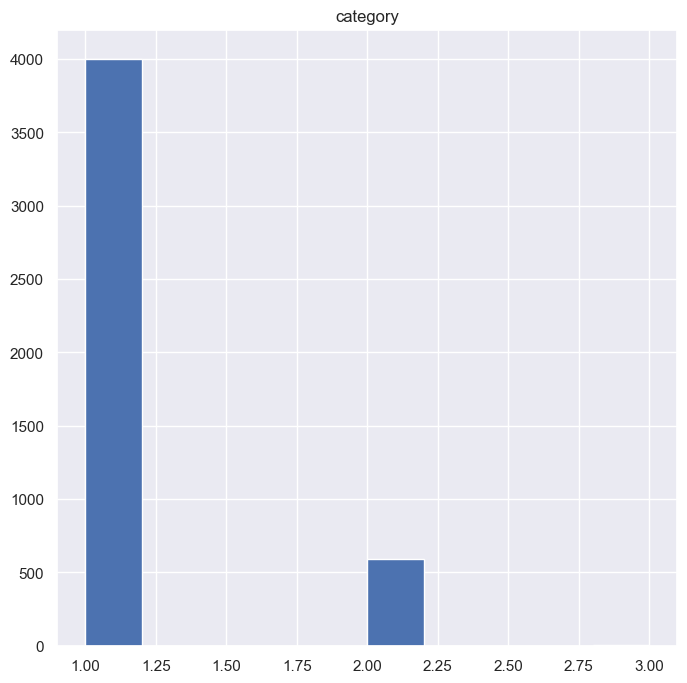

In [85]:
wiki_2009_categories = pd.read_csv('./wikispeedia_paths-and-graph/categories.tsv', delim_whitespace=True, names=['article', 'category'], comment='#')
wiki_2009_categories.groupby('article').count().hist()
wiki_2009_categories = wiki_2009_categories.groupby('article').sample(1)
wiki_2009_categories['category'] = wiki_2009_categories['category'].str.extract(r'subject\.([a-zA-Z]*)')
wiki_2009_categories = wiki_2009_categories.set_index('article')
article_cat = wiki_2009_categories.to_dict()['category']
wiki_2009_categories.head()

In [88]:
def map_categories(model, article_2_cat):
    cat = []
    for k in model.wv.key_to_index.keys():
        if k in article_2_cat:
            cat.append(article_2_cat[k])
        else:
            cat.append("NA")

    return cat

def plot_embedding(embedding, cat, title):
    palette = {k:v for (k, v) in zip(set(cat), sns.color_palette('tab20'))}
    sns.set(rc={'figure.figsize':(8,8)})
    ax = sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], size=1, data=pd.DataFrame({'category':cat}), hue='category', palette=palette)
    handles, labels = plt.gca().get_legend_handles_labels()
    tmp = sorted(list(zip(handles, labels)), key=lambda x: x[1])[1:]
    plt.legend([x[0] for x in tmp],[x[1] for x in tmp])
    plt.title(title)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


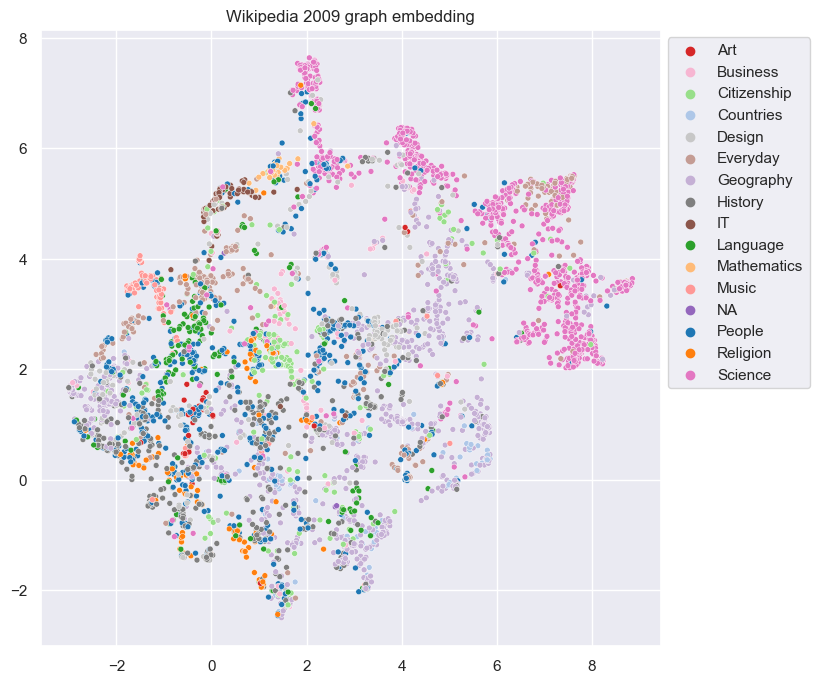

In [89]:
reducer = umap.UMAP()
embedding_2009 = reducer.fit_transform(model_2009.wv.get_normed_vectors())

cat = map_categories(model_2009, article_cat)
plot_embedding(embedding_2009, cat, 'Wikipedia 2009 graph embedding')

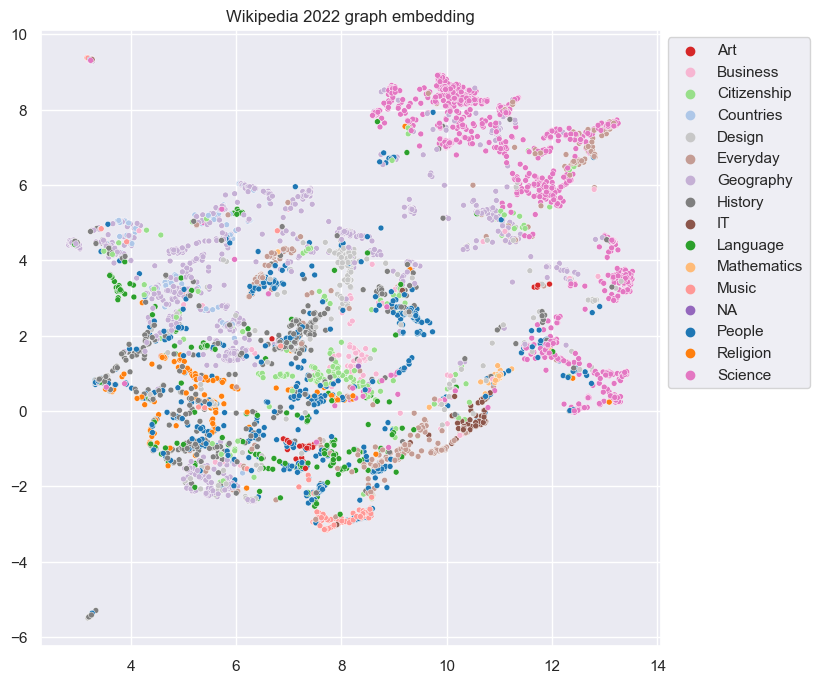

In [90]:
reducer = umap.UMAP()
embedding_2022 = reducer.fit_transform(model_2022.wv.get_normed_vectors())

cat = map_categories(model_2022, article_cat)
plot_embedding(embedding_2022, cat, 'Wikipedia 2022 graph embedding')

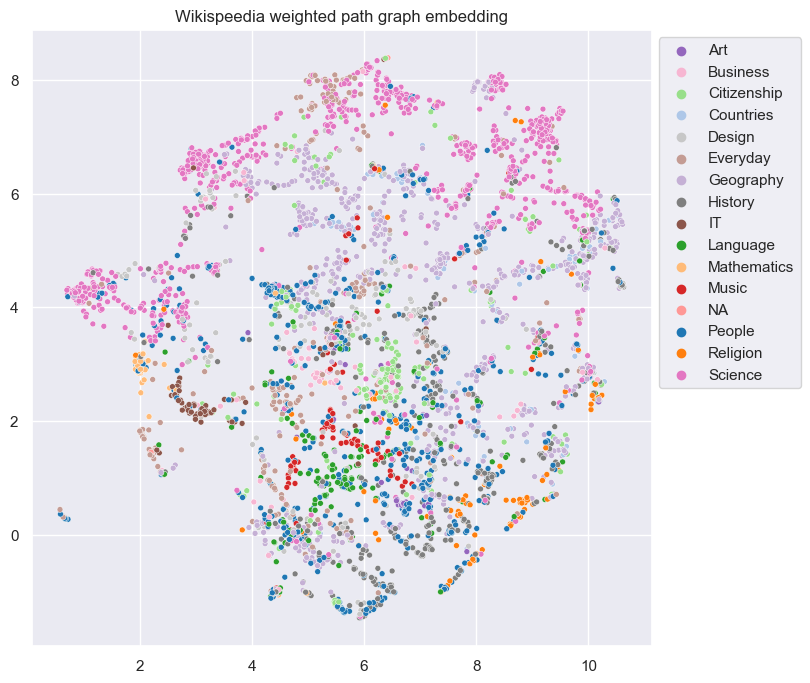

In [108]:
reducer = umap.UMAP()
embedding_wikispeedia_paths = reducer.fit_transform(model_wikispeedia_paths.wv.get_normed_vectors())

cat = map_categories(model_wikispeedia_paths, article_cat)
plot_embedding(embedding_wikispeedia_paths, cat, 'Wikispeedia weighted path graph embedding')


In [99]:
def hits_categorize(graph):
    graph_hits = nx.hits(graph)

    graph_2_hits_cat = {}
    for (k1, v1), (k2, v2) in zip(graph_hits[0].items(), graph_hits[1].items()):
        if v1 > v2:
            graph_2_hits_cat[k1] = 'hub'
        else:
            graph_2_hits_cat[k1] = 'authority'
    
    return graph_2_hits_cat


/Users/riko/miniconda3/envs/ada/lib/python3.9/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


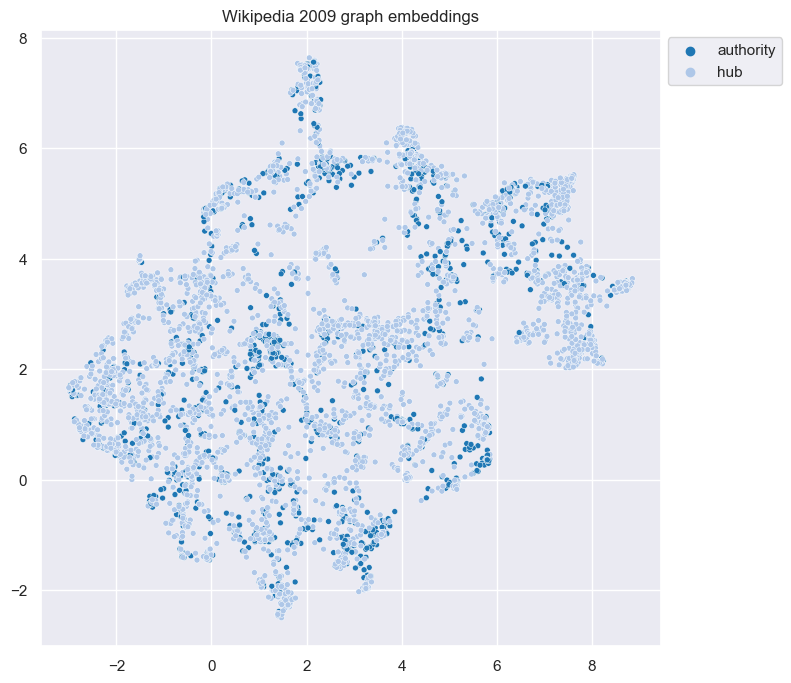

In [98]:
wiki_2009_2_hits = hits_categorize(graph_2009)
cat = map_categories(model_2009, wiki_2009_2_hits)
plot_embedding(embedding_2009, cat, 'Wikipedia 2009 graph embeddings')

/Users/riko/miniconda3/envs/ada/lib/python3.9/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


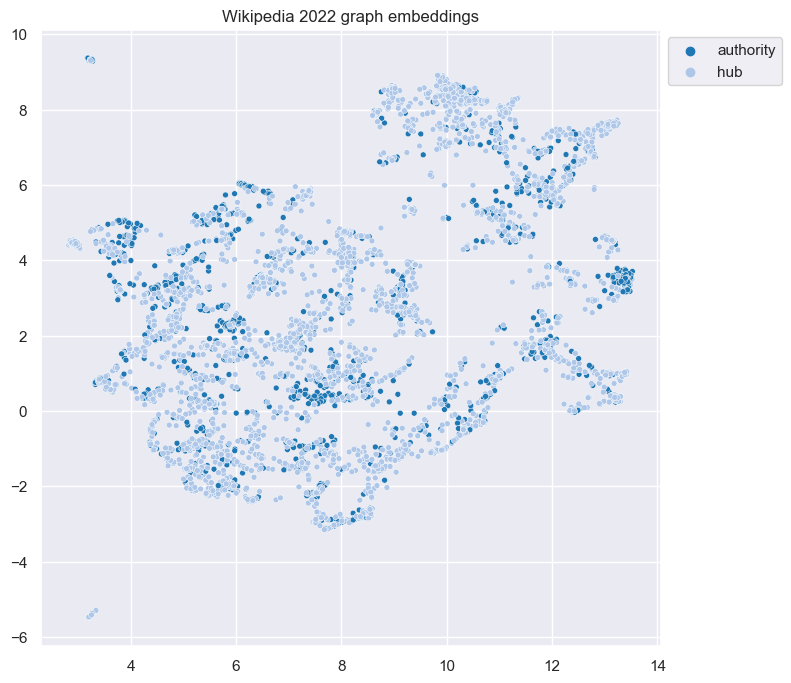

In [100]:
wiki_2022_2_hits = hits_categorize(graph_2022)
cat = map_categories(model_2022, wiki_2022_2_hits)
plot_embedding(embedding_2022, cat, 'Wikipedia 2022 graph embeddings')

/Users/riko/miniconda3/envs/ada/lib/python3.9/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


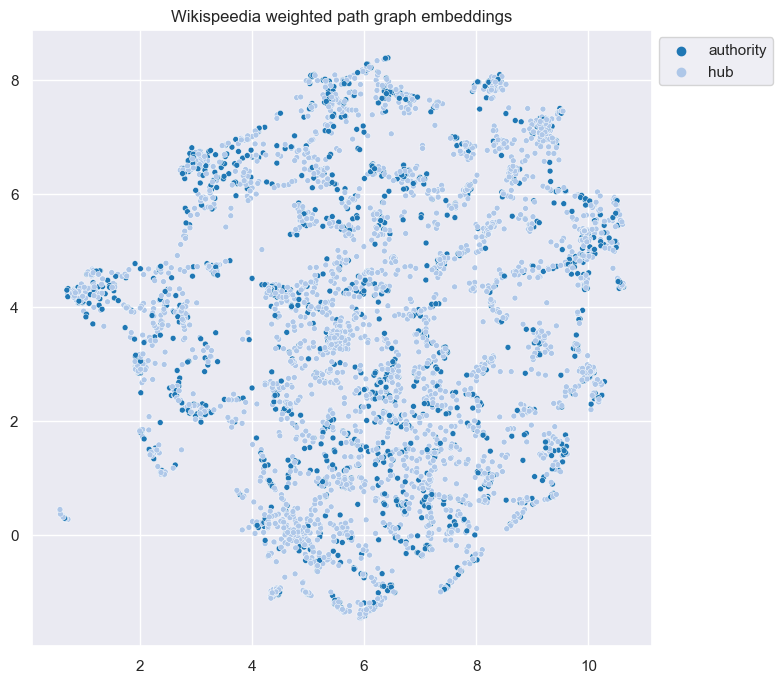

In [109]:
wikispeedia_2_hits = hits_categorize(graph_wikispeedia_paths)
cat = map_categories(model_wikispeedia_paths, wikispeedia_2_hits)
plot_embedding(embedding_wikispeedia_paths, cat, 'Wikispeedia weighted path graph embeddings')